# Paper replication

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from utils import all_combinations

M = 2
D = 3 * 3
ALL_INPUTS = all_combinations(M, D)

## Define CAs and training data

In [3]:
from ca_funcs import make_table_walk, make_ca

def sample_CAs(seed=None):
    if seed:
        np.random.seed(seed)
        
    inputs = ALL_INPUTS
    outputs = make_table_walk(len(ALL_INPUTS))
    for o in outputs:
        yield make_ca(inputs, o)
        
def generate_CA_train_data(ca, height=10, width=10, n_samples=500):
    X_train = np.random.choice([0,1], (n_samples, height, width), p=[.5,.5])
    Y_train = ca(tf.convert_to_tensor(X_train, tf.float32))
    return (X_train, Y_train)

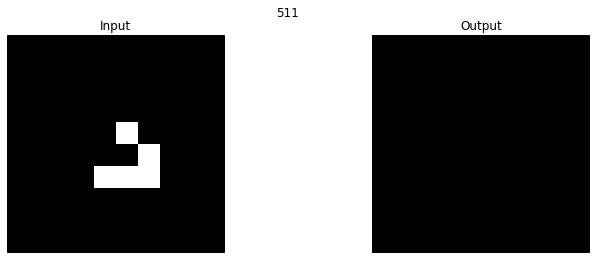

In [4]:
from ca_funcs import make_glider
from IPython.display import clear_output

np.random.seed(0)

for i, ca in enumerate(sample_CAs()):
    X_test = tf.convert_to_tensor(make_glider(10).reshape(1, 10, 10), tf.float32)
    Y_test = ca(X_test)
    
    plt.figure(figsize=(12,4))
    plt.suptitle(i)

    plt.subplot(1,2,1)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(1,2,2)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Output")
    
    plt.show()
    plt.close()
    clear_output(wait=True)

## Find entropy of the training CA

In [5]:
from collections import Counter
from utils import shannon_entropy

def ca_entropy(ca):
    inputs = tf.convert_to_tensor(ALL_INPUTS, tf.float32)
    outputs = ca(inputs)
    output_counts = np.array(list(Counter(tuple(tf.reshape(o, [-1]).numpy()) for o in outputs).values()))
    output_ps = output_counts / len(inputs)
    return shannon_entropy(output_ps)

512it [01:15,  6.82it/s]


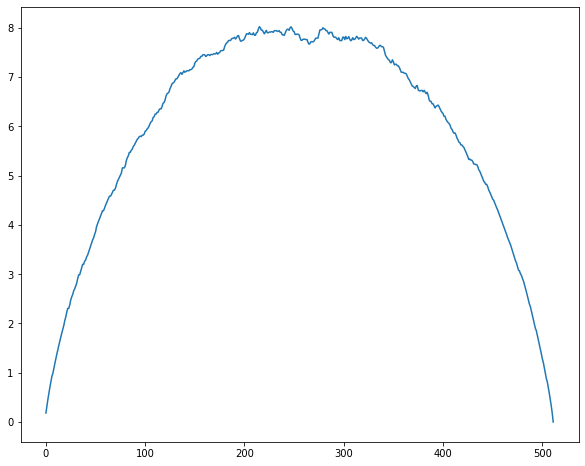

In [6]:
entropies = [ca_entropy(a) for a in tqdm(sample_CAs(seed=0))]
plt.plot(entropies)

## Define the model

In [7]:
from train_ca import initialize_model

seed = 0
print('seed =', seed)

np.random.seed(seed)
tf.random.set_seed(seed)

num_classes = 2
samples = 500
input_dims = [10, 10]
layer_dims = [100] + [100] * 11 # neighborhood conv + mlpconv layers
batch_size = 10
num_batches = samples / batch_size
learning_rate = 1e-4
training_epochs = 100 # 1500
display_step = int(training_epochs/10)
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model = initialize_model(input_dims, layer_dims)
model.compile(optimizer=optimizer, loss=loss)
model.summary()

seed = 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wraparound2d (Wraparound2D)  (None, 12, 12, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 100)       1000      
_________________________________________________________________
reshape (Reshape)            (None, 100, 100)          0         
_________________________________________________________________
dense (Dense)                (None, 100, 100)          10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100, 100)  

## Define the learning loop

In [8]:
def learn_CA(ca, model):
    X_train, Y_train = generate_CA_train_data(ca, *input_dims, n_samples=samples)
    model.fit(x=X_train, y=Y_train, epochs=training_epochs, batch_size=batch_size)

## Train the model

In [9]:
ca = list(sample_CAs(seed=0))[250]
learn_CA(ca, model)

Epoch 1/100
50/50 [==============================] - 1s 18ms/step - loss: 649.3586
Epoch 2/100
50/50 [==============================] - 1s 19ms/step - loss: 48.3715
Epoch 3/100
50/50 [==============================] - 1s 18ms/step - loss: 20.5533
Epoch 4/100
50/50 [==============================] - 1s 17ms/step - loss: 6.7166
Epoch 5/100
50/50 [==============================] - 1s 18ms/step - loss: 1.6945
Epoch 6/100
50/50 [==============================] - 1s 23ms/step - loss: 0.5224
Epoch 7/100
50/50 [==============================] - 1s 22ms/step - loss: 0.3301
Epoch 8/100
50/50 [==============================] - 1s 19ms/step - loss: 0.2868
Epoch 9/100
50/50 [==============================] - 2s 30ms/step - loss: 0.2639
Epoch 10/100
50/50 [==============================] - 1s 21ms/step - loss: 0.2482
Epoch 11/100
50/50 [==============================] - 1s 18ms/step - loss: 0.2367
Epoch 12/100
50/50 [==============================] - 1s 18ms/step - loss: 0.2280
Epoch 13/100
50/50 [=

[]

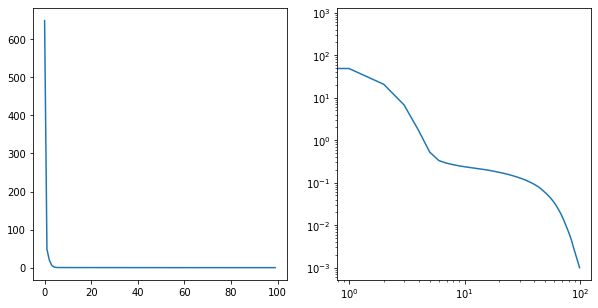

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.subplot(122)
plt.plot(model.history.history['loss'])
plt.loglog()

Text(0.5, 1.0, 'Diff')

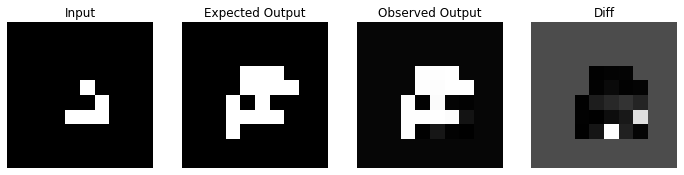

In [11]:
from ca_funcs import make_glider

# x = np.random.choice([0, 1], size=100)
x = make_glider(10)
X_test = tf.convert_to_tensor(x.reshape(1, 10, 10), tf.float32)
Y_test = ca(X_test)
Y_pred = model(X_test)

plt.figure(figsize=(12,4))

plt.subplot(141)
plt.imshow(X_test[0])
plt.axis('off')
plt.title("Input")

plt.subplot(142)
plt.imshow(Y_test[0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(143)
plt.imshow(Y_pred[0])
plt.axis('off')
plt.title("Observed Output")

plt.subplot(144)
plt.imshow(abs(Y_pred[0] - Y_test[0]))
plt.axis('off')
plt.title("Diff")

## Find model entropies

In [12]:
from ca_funcs import get_network_entropies

get_activations = tf.keras.backend.function(model.input, [model.layers[i].output for i in np.r_[1, 3:len(model.layers)-2]])

X_test = tf.convert_to_tensor(np.random.choice([0, 1], (500, 10, 10)), tf.float32)

layer_activations = np.array([layer.reshape(500, 100, 100) for layer in get_activations(X_test)])
binary_activations = np.digitize(layer_activations, [0], right=True)
entropies = get_network_entropies(binary_activations)

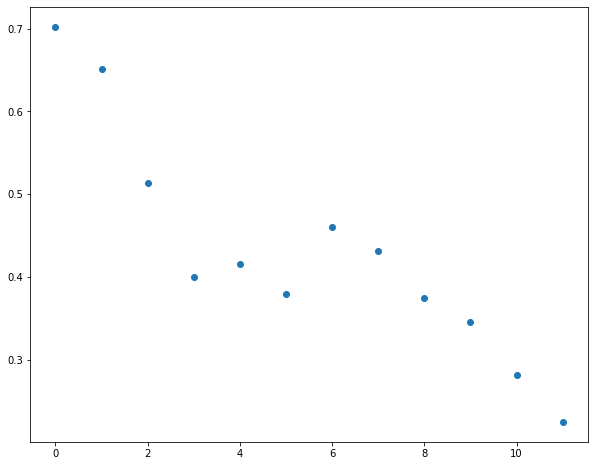

In [15]:
plt.plot(np.array(entropies[2]).mean(axis=1), 'o')

In [14]:
entropies

(6.2330942336477335,
 [6.2330942336477335,
  6.2330942336477335,
  6.233094233647733,
  6.225141883066019,
  6.2330942336477335,
  6.2303951149657,
  6.2330942336477335,
  6.2330942336477335,
  6.233094233647733,
  6.230322444978835,
  6.227527806112841,
  5.650075574039603],
 [array([ 0.21542131,  0.93066515,  0.29983786,  0.81458961,  0.97238283,
          0.95944232,  0.97367813,  0.43533392,  0.81361545,  0.37422783,
          0.71956181,  0.99926675,  0.22534645,  0.9226396 ,  0.41092741,
          0.87013795,  0.93362072,  0.97752846,  0.2577588 ,  0.70276665,
          0.99583387,  0.41989923,  0.99309505,  0.54731449,  0.77011953,
          0.54446212,  0.64903079,  0.98166747,  0.55940949,  0.96806115,
          0.80978486,  0.63224819,  0.96318045,  0.94896788,  0.96532669,
          0.59477362,  0.57393322,  0.87577051,  0.13017422,  0.28750039,
          0.38452898,  0.57913549,  0.9762794 ,  0.99390183,  0.94697889,
          0.98964311,  0.51085786,  0.84060236,  0.961361